In [3]:
import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.stats            import entropy

import pandas as pd
import os, glob
import re

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne   import _joint_probabilities

import seaborn as sns
import matplotlib.pyplot as plt

dat_dir = "/data/clintko/SMPK"
fhead   = "ep8cs_tsne_jsdiv"
#fhead   = "ep8cs_tsne_jsdiv"
pal = sns.light_palette("blue", as_cmap=True)

In [4]:
%matplotlib inline

In [5]:
def read_pmat(fnames):
    """stack the pmat of MPSK cal"""
    mat = [np.load(fn) for fn in fnames]
    mat = np.stack(mat, axis=2)
    return mat

def get_t1t2(mat_raw_vs_cal):
    """get the t1 + t2 from diagonal of raw vs MPSK cal"""
    diag = np.diag(mat_raw_vs_cal)
    mat_out = np.zeros((18, 18))
    for i in range(18):
        for j in range(18):
            mat_out[i, j] = diag[i] + diag[j]
    return mat_out

In [6]:
fnames = glob.glob(os.path.join(dat_dir, "ep8cs_dat_cal_prior*"))
priors = [re.findall("prior(.*).txt", x)[0] for x in fnames]
priors = np.array(priors)

In [38]:
### js div matrix: Raw x Raw
jsdiv_raw = np.load("/data/clintko/SMPK/ep8cs_tsne_jsdiv_raw.npy")

### js div matrix: MPSK calibrated x MPSK calibrated
fnames = glob.glob("/data/clintko/SMPK/ep8cs_tsne_jsdiv_cal_prior*.npy")
jsdiv_cal = read_pmat(fnames)

### js div matrix: raw vs MPSK calibrated
fnames = glob.glob("/data/clintko/SMPK/ep8cs_tsne_jsdiv_raw_cal_prior*.npy")
jsdiv_raw_cal = read_pmat(fnames)

###
jsdiv_t1t2 = [get_t1t2(jsdiv_raw_cal[:, :, idx]) for idx in range(18)]
jsdiv_t1t2 = np.stack(jsdiv_t1t2, axis = 2)

###
jsdiv_raw2 = [jsdiv_raw for _ in range(18)]
jsdiv_raw2 = np.stack(jsdiv_raw2, axis = 2)

###
idx    = np.array([np.all(jsdiv_t1t2[:, :, idx] != 0) for idx in range(18)])
p      = priors[idx].astype(int)
diff   = jsdiv_cal[:, :, idx] - jsdiv_raw2[:, :, idx]
metric = diff / jsdiv_t1t2[:, :, idx]

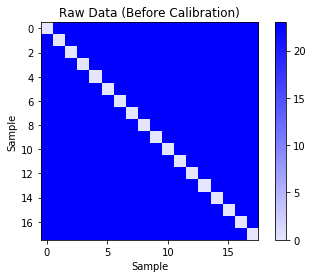

In [9]:
mat = jsdiv_raw
plt.imshow(mat, interpolation='none', cmap=pal)
plt.title("Raw Data (Before Calibration)")
plt.xlabel("Sample")
plt.ylabel("Sample")
plt.colorbar()

In [11]:
print(jsdiv_raw[:2, :2])

[[ 0.         22.92807331]
 [22.92807331  0.        ]]


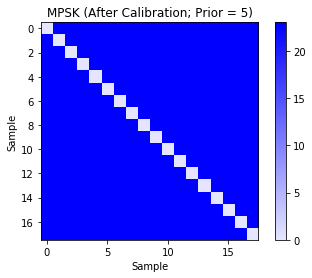

In [15]:
mat = jsdiv_cal[:, :, 0]
plt.imshow(mat, interpolation='none', cmap=pal)
plt.title("MPSK (After Calibration; Prior = 5)")
plt.xlabel("Sample")
plt.ylabel("Sample")
plt.colorbar()
pass

In [16]:
print(jsdiv_cal[:2, :2, 0])

[[ 0.         23.00765557]
 [23.00765557  0.        ]]


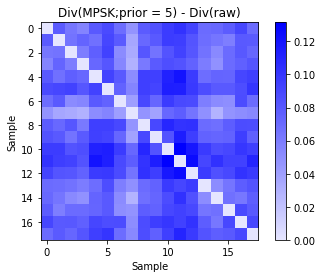

In [29]:
mat = jsdiv_cal[:, :, 0] - jsdiv_raw
plt.imshow(mat, interpolation='none', cmap=pal)
plt.title("Div(MPSK;prior = 5) - Div(raw)")
plt.xlabel("Sample")
plt.ylabel("Sample")
plt.colorbar()
pass

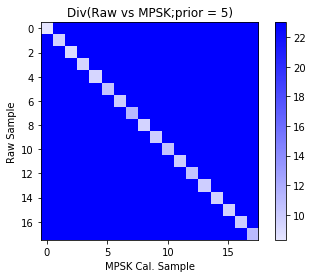

In [31]:
mat = jsdiv_raw_cal[:, :, 0]
plt.imshow(mat, interpolation='none', cmap=pal)
plt.title("Div(Raw vs MPSK;prior = 5)")
plt.xlabel("MPSK Cal. Sample")
plt.ylabel("Raw Sample")
plt.colorbar()
pass

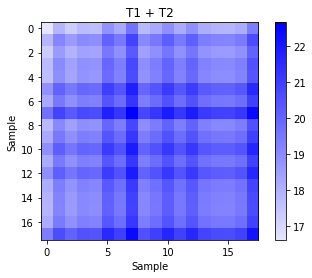

In [32]:
mat = jsdiv_t1t2[:, :, 0]
plt.imshow(mat, interpolation='none', cmap=pal)
plt.title("T1 + T2")
plt.xlabel("Sample")
plt.ylabel("Sample")
plt.colorbar()
pass

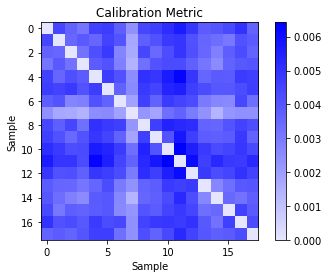

In [35]:
mat = (jsdiv_cal[:, :, 0] - jsdiv_raw) / jsdiv_t1t2[:, :, 0]
plt.imshow(mat, interpolation='none', cmap=pal)
plt.title("Calibration Metric")
plt.xlabel("Sample")
plt.ylabel("Sample")
plt.colorbar()
pass

In [44]:
diff.shape

(18, 18, 16)

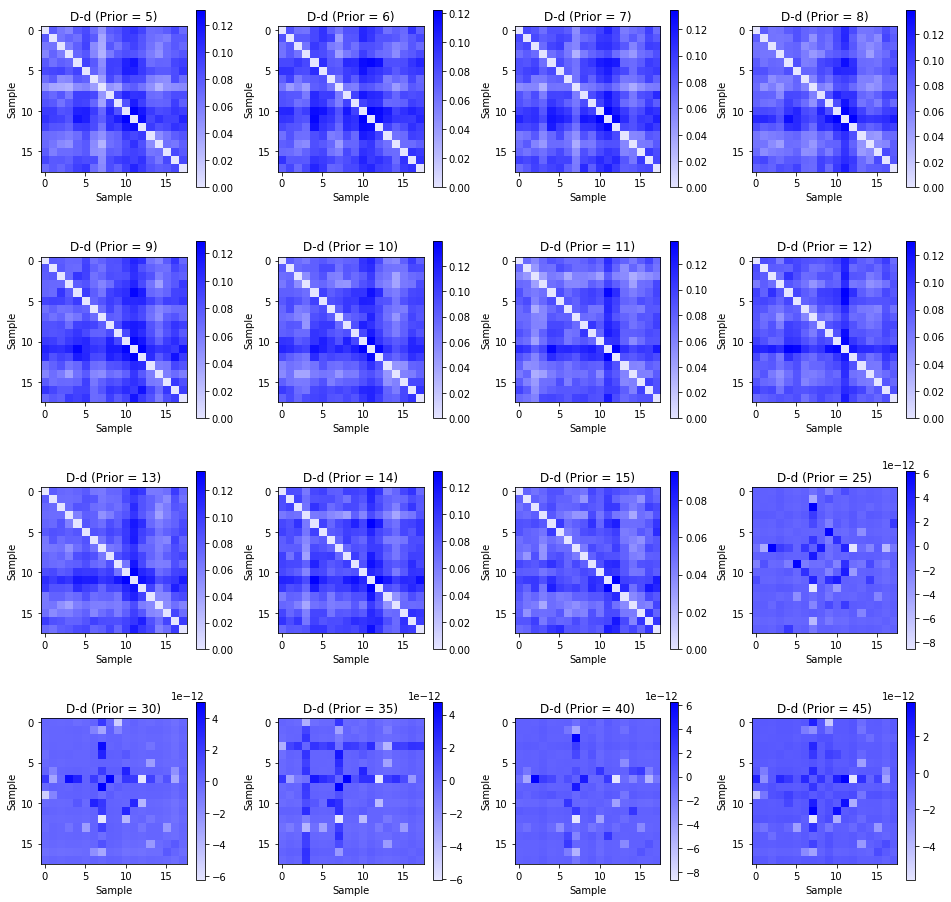

In [52]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(4*4, 4*4))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.ravel()
    
for idx in range(16):
    ax = axes[idx]
    cax = ax.imshow(diff[:, :, idx], cmap=pal)
    ax.set_title("D-d (Prior = " + str(p[idx]) + ")")
    ax.set_xlabel("Sample"); ax.set_ylabel("Sample")
    fig.colorbar(cax, ax=ax)
pass

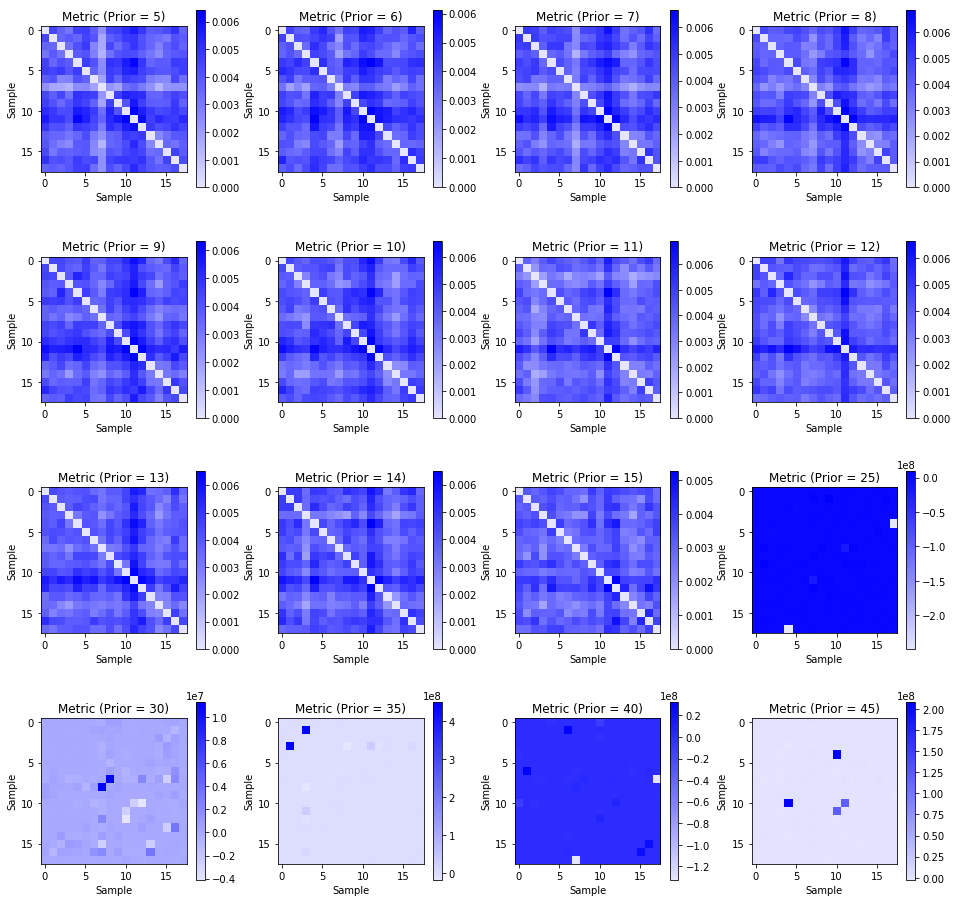

In [53]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(4*4, 4*4))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.ravel()
    
for idx in range(16):
    ax = axes[idx]
    cax = ax.imshow(metric[:, :, idx], cmap=pal)
    ax.set_title("Metric (Prior = " + str(p[idx]) + ")")
    ax.set_xlabel("Sample"); ax.set_ylabel("Sample")
    fig.colorbar(cax, ax=ax)
pass

In [ ]:
idx    = np.array([np.all(jsdiv_t1t2[:, :, idx] != 0) for idx in range(18)])
p      = priors[idx].astype(int)
diff   = jsdiv_cal[:, :, idx] - jsdiv_raw2[:, :, idx]
metric = diff / jsdiv_t1t2[:, :, idx]

In [58]:
val = metric.sum(axis = 0).sum(axis = 0)
val

array([ 1.22975126e+00,  1.24617987e+00,  1.30286306e+00,  1.30313951e+00,
        1.29189874e+00,  1.30358085e+00,  1.23258836e+00,  1.26244435e+00,
        1.25512377e+00,  1.26697743e+00,  9.71384252e-01, -4.82812338e+08,
        2.44943611e+07,  9.16436151e+08, -1.55655999e+08,  6.38870177e+08])

638870177.1060317


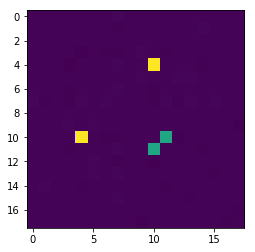

In [56]:
print(metric[:, :, -1].sum(axis = 0).sum(axis = 0))
#plt.imshow(metric[:, :, -1])